In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dt_clf = DecisionTreeClassifier(random_state=156)

iris_data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris_data.data, iris_data.target, test_size=0.2, random_state=11)

dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=156)

In [43]:
from sklearn.tree import export_graphviz

export_graphviz(dt_clf, out_file='tree.dot', class_names = iris_data.target_names,
               feature_names = iris_data.feature_names, impurity = True, filled = True)

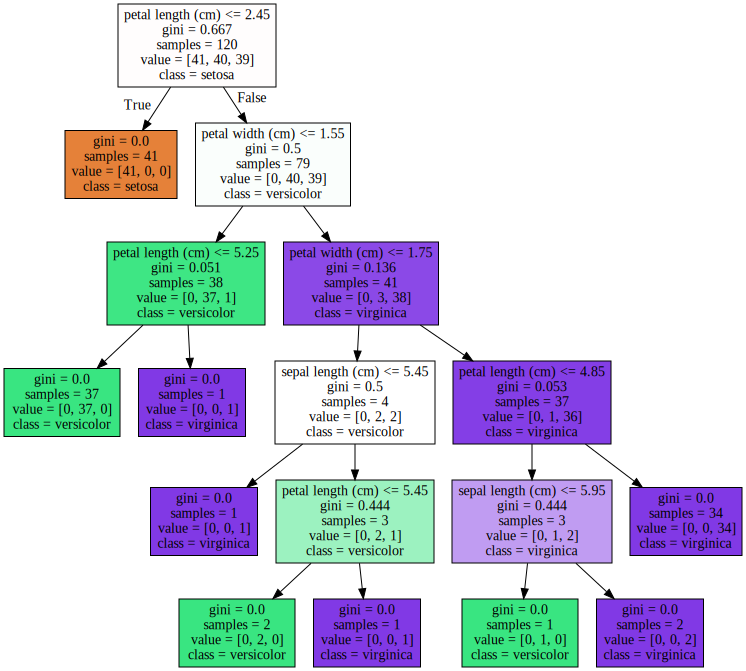

In [44]:
import graphviz
with open('tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)


Feature importances: 
[0.025 0.    0.555 0.42 ]
sepal length (cm): 0.025
sepal width (cm): 0.000
petal length (cm): 0.555
petal width (cm): 0.420


<AxesSubplot:>

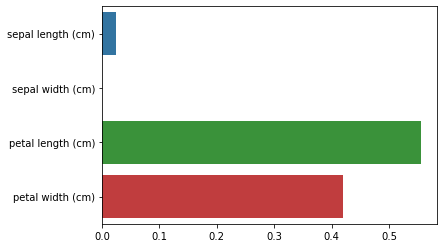

In [45]:
import seaborn as sns
import numpy as np
%matplotlib inline

print('Feature importances: \n{0}'.format(np.round(dt_clf.feature_importances_,3)))

for name, value in zip(iris_data.feature_names, dt_clf.feature_importances_):
    print('{0}: {1:.3f}'.format(name, value))
    
sns.barplot(x=dt_clf.feature_importances_, y=iris_data.feature_names)

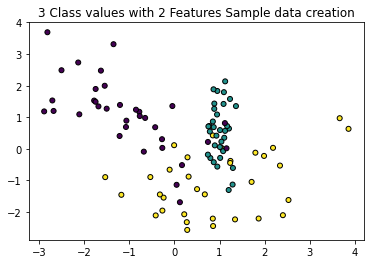

In [46]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
%matplotlib inline

plt.title("3 Class values with 2 Features Sample data creation")

X_features, y_labels = make_classification(n_features=2, n_redundant=0, 
                                           n_informative=2, n_classes=3, 
                                           n_clusters_per_class=1, random_state=0)

plt.scatter(X_features[:, 0], X_features[:, 1], marker='o', c=y_labels, s=25, edgecolor = 'k')

In [47]:
def visualize_boundary(model, X, y):
    fig,ax = plt.subplots()
    
    # 학습 데이타 scatter plot으로 나타내기
    ax.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap='rainbow', edgecolor='k',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim_start , xlim_end = ax.get_xlim()
    ylim_start , ylim_end = ax.get_ylim()
    
    # 호출 파라미터로 들어온 training 데이타로 model 학습 . 
    model.fit(X, y)
    # meshgrid 형태인 모든 좌표값으로 예측 수행. 
    xx, yy = np.meshgrid(np.linspace(xlim_start,xlim_end, num=200),np.linspace(ylim_start,ylim_end, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # contourf() 를 이용하여 class boundary 를 visualization 수행. 
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='rainbow', clim=(y.min(), y.max()),
                           zorder=1)

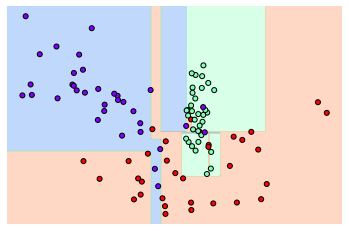

In [48]:
dt_clf = DecisionTreeClassifier().fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels)

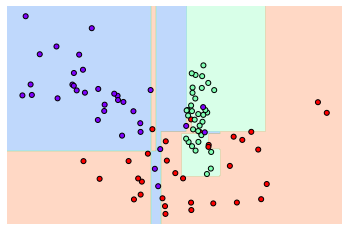

In [49]:
t_clf = DecisionTreeClassifier(min_samples_leaf=6).fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels)

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

feature_name_df = pd.read_csv(r'C:\Users\yujin\Desktop\data\human_activity\features.txt', 
                              sep='\s+', header=None, names=['column_index', 'column_name'])

feature_name = feature_name_df.iloc[:, 1].values.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [51]:
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index'] > 1].count())
feature_dup_df[feature_dup_df['column_index'] > 1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [52]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [53]:
import pandas as pd

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv(r'C:\Users\yujin\Desktop\data\human_activity\features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv(r'C:\Users\yujin\Desktop\data\human_activity\X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv(r'C:\Users\yujin\Desktop\data\human_activity\X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv(r'C:\Users\yujin\Desktop\data\human_activity\y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv(r'C:\Users\yujin\Desktop\data\human_activity\y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

In [54]:
X_train, X_test, y_train, y_test = get_human_dataset()

In [55]:
print('## 학습 피처 데이터셋 info()')
print(X_train.info())

## 학습 피처 데이터셋 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [56]:
print(y_train['action'].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('Decision Tree 예측 정확도 : {0:.4f}'.format(accuracy))

print('\nDecisionTreeClassifier 기본 하이퍼파라미터:\n', dt_clf.get_params())

Decision Tree 예측 정확도 : 0.8548

DecisionTreeClassifier 기본 하이퍼파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


In [58]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [6, 8, 10, 12, 16, 20, 24]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼파라미터: ', grid_cv.best_params_)


Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV 최고 평균 정확도 수치: 0.8513
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 16}


In [59]:
cv_results_df = pd.DataFrame(grid_cv.cv_results_)
cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.850791
1,8,0.851069
2,10,0.851209
3,12,0.844135
4,16,0.851344
5,20,0.850800
6,24,0.849440


In [60]:
max_depths = [6, 8, 10, 12, 16, 20, 24]
for depth in max_depths:
    dt_clf = DecisionTreeClassifier(max_depth=depth, random_state=156)
    dt_clf.fit(X_train, y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print('max_depth = {0} 정확도 : {1:.4f}'.format(depth, accuracy))

max_depth = 6 정확도 : 0.8558
max_depth = 8 정확도 : 0.8707
max_depth = 10 정확도 : 0.8673
max_depth = 12 정확도 : 0.8646
max_depth = 16 정확도 : 0.8575
max_depth = 20 정확도 : 0.8548
max_depth = 24 정확도 : 0.8548


In [61]:
params = {
    'max_depth' : [6, 8, 10, 12, 16, 20, 24],
    'min_samples_split' : [16, 24]
}

params = {
    'max_depth' : [6, 8, 10, 12, 16, 20, 24],
    'min_samples_split' : [16, 24]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼파라미터: ', grid_cv.best_params_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
GridSearchCV 최고 평균 정확도 수치: 0.8549
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 8, 'min_samples_split': 16}


In [62]:
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred1)
print('Desicion Tree 예측 정확도: {0:.4f}'.format(accuracy))

Desicion Tree 예측 정확도: 0.8717


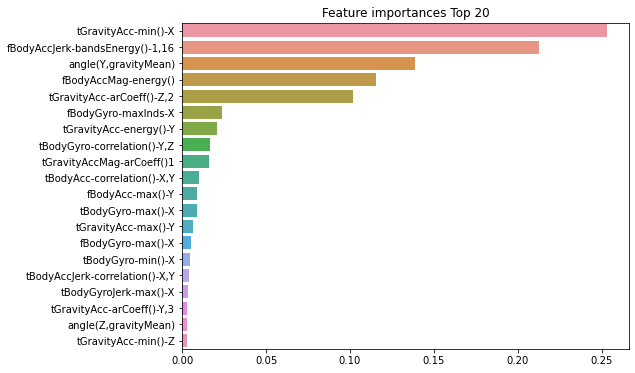

In [64]:
import seaborn as sns

ftr_importances_values = best_df_clf.feature_importances_
# Top 중요도로 정렬을 쉽게 하고, 시본(Seaborn)의 막대그래프로 쉽게 표현하기 위해 Series변환
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns  )
# 중요도값 순으로 Series를 정렬
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

In [65]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns = cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [66]:
logistic_regression = LogisticRegression()
knn = KNeighborsClassifier(n_neighbors=8)

voting_model = VotingClassifier(estimators=[ ('LogisticRegression', logistic_regression), ('KNN', knn)], voting='soft')

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=156)

voting_model.fit(X_train, y_train)
pred = voting_model.predict(X_test)
print('보팅 분류기의 정확도: {0: .4f}'.format(accuracy_score(y_test, pred)))

classifiers = [logistic_regression, knn]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))

보팅 분류기의 정확도:  0.9474
LogisticRegression 정확도: 0.9386
KNeighborsClassifier 정확도: 0.9386


In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도: {:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9253


In [68]:
from sklearn.model_selection import GridSearchCV

params = { 'n_estimators' : [10, 100],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
}

rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9222


In [69]:
#위의 결과로 나온 최적 하이퍼 파라미터로 다시 모델을 학습하여 테스트 세트 데이터에서 예측 성능을 측정
rf_clf1 = RandomForestClassifier(n_estimators = 100, 
                                max_depth = 12,
                                min_samples_leaf = 8,
                                min_samples_split = 8,
                                random_state = 0,
                                n_jobs = -1)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,pred)))

예측 정확도: 0.9230


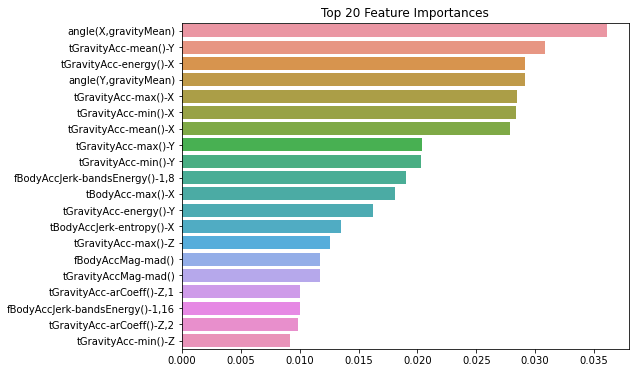

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Top 20 Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()